In [21]:
import cdsapi
from dotenv import load_dotenv
import os

In [22]:
load_dotenv("copernicus_api.env")

cds = cdsapi.Client(
    url="https://cds.climate.copernicus.eu/api/v2",
    key=f"{os.getenv('UID')}:{os.getenv('API_KEY')}"
)

In [44]:
deg_limit_north = 90
deg_limit_south = -90
deg_limit_west = 181
deg_limit_east = 180

In [45]:
response = cds.retrieve(
    'reanalysis-era5-single-levels',
    {
        "product_type": "reanalysis",
        "format": "grib",
        "variable": "2m_temperature",
        "area": [
            deg_limit_north, deg_limit_west, deg_limit_south, deg_limit_east
        ],
        "year": '2020',
        "month": '03',
        "day": [f"{day:02d}" for day in range(1, 2)],
        "time": [f"{hour:02d}:00" for hour in range(24)]

    }, 'download.grib')

print(response)

2024-04-07 13:29:28,601 INFO Welcome to the CDS
2024-04-07 13:29:28,602 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2024-04-07 13:29:28,817 INFO Request is queued
2024-04-07 13:29:29,930 INFO Request is running
2024-04-07 13:29:33,836 INFO Request is completed
2024-04-07 13:29:33,837 INFO Downloading https://download-0006-clone.copernicus-climate.eu/cache-compute-0006/cache/data9/adaptor.mars.internal-1712489369.145587-23843-2-6fc54db2-c55e-4d7f-adbb-38f773b7ee27.grib to download.grib (47.4M)
2024-04-07 13:29:55,052 INFO Download rate 2.2M/s   


Result(content_length=49734720,content_type=application/x-grib,location=https://download-0006-clone.copernicus-climate.eu/cache-compute-0006/cache/data9/adaptor.mars.internal-1712489369.145587-23843-2-6fc54db2-c55e-4d7f-adbb-38f773b7ee27.grib)


In [46]:
import subprocess
import os 

cdo_convert_to_netcdf_command = "cdo -f nc copy download.grib download_temp.nc"
subprocess.run(cdo_convert_to_netcdf_command, shell=True)
rename_variable_from_var167_to_tas_command = "cdo chname,var167,tas download_temp.nc download_temp_temp.nc"
subprocess.run(rename_variable_from_var167_to_tas_command, shell=True)

if os.path.exists("download.nc"):
    os.remove("download.nc")
if os.path.exists("download_temp.nc"):
    os.remove("download_temp.nc")
if os.path.exists("download_temp_temp.nc"):
    # move the file to the correct name
    os.rename("download_temp_temp.nc", "download.nc")

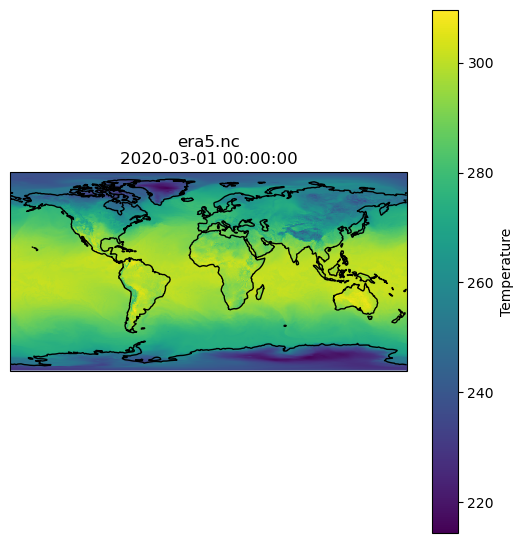

In [47]:
from crai.station_reconstruct.utils import DatasetPlotter, DataSet, Station

dataset = DataSet(path="download.nc", name="era5.nc")
plotter = DatasetPlotter(dataset)
plotter.plot()


In [23]:
import xarray as xr
xr.open_dataset("download.nc")

<xarray.Dataset> Size: 1kB
Dimensions:  (time: 6, lon: 9, lat: 5)
Coordinates:
  * time     (time) datetime64[ns] 48B 2023-03-01 ... 2023-03-03T12:00:00
  * lon      (lon) float64 72B 9.0 9.25 9.5 9.75 10.0 10.25 10.5 10.75 11.0
  * lat      (lat) float64 40B 54.0 53.75 53.5 53.25 53.0
Data variables:
    tas      (time, lat, lon) float32 1kB ...
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Fri Apr 05 20:38:18 2024: cdo chname,var167,tas download_te...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...

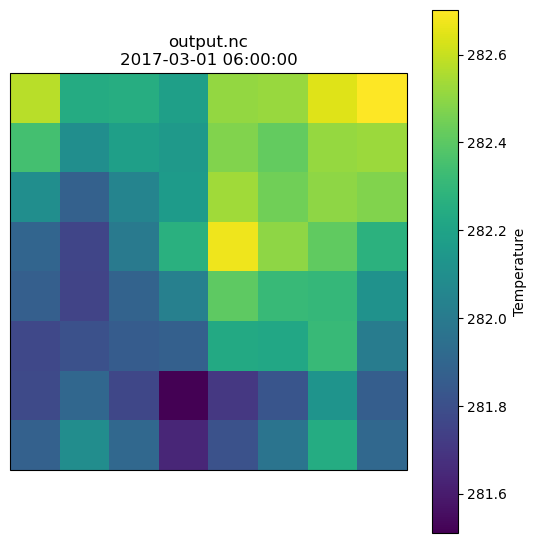

<xarray.Dataset> Size: 5kB
Dimensions:  (lon: 8, lat: 8, time: 20)
Coordinates:
  * lon      (lon) float64 64B -106.1 -105.8 -105.6 ... -104.8 -104.6 -104.3
  * lat      (lat) float64 64B 40.8 40.55 40.3 40.05 39.8 39.55 39.3 39.05
  * time     (time) datetime64[ns] 160B 2017-03-01T06:00:00 ... 2017-04-05T03...
Data variables:
    tas      (time, lat, lon) float32 5kB ...
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Infilled using CRAI (Climate Reconstruction AI: https://git...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...
--- 0.0036029815673828125 seconds ---
--- 0.0003521442413330078 seconds ---


In [20]:
output_path = "/Users/timo.wacke/VsCodeProjects/digital-twin-for-weather-station/output_dir/tmpopnbrxe8/output_output.nc"
plotter = DatasetPlotter(DataSet(output_path, "output.nc"))
plotter.plot()
import xarray as xr
x_array = xr.open_dataset(output_path)
print(x_array)

import time
start_time = time.time()

df = x_array.to_dataframe()
df_combined = df.groupby([df.index.get_level_values('time')]).mean()

print("--- %s seconds ---" % (time.time() - start_time))

import pandas as pd

start_time = time.time()

tas_values = x_array["tas"].values[:].mean(axis=(1,2))
hours = x_array.time.values

conventional_df = pd.DataFrame(data={"tas": tas_values}, index=hours)

print("--- %s seconds ---" % (time.time() - start_time))